In [1]:
import torch
import torch.nn.functional as F

In [2]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
loadstr = '/home/bstadt/root/tlm/models/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
tokenizer = AutoTokenizer.from_pretrained(loadstr)

/home/bstadt/root/tlm/tlmenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_top_fills(phrase, model, tokenizer, top_k=5):
    """
    Get the top k most likely fills for a phrase with mask tokens.
    
    Args:
        phrase: String with [MASK] tokens to fill
        model: The language model
        tokenizer: The tokenizer
        top_k: Number of top fills to return (default 5)
    
    Returns:
        List of tuples (fill_tokens, probability) for top k fills
    """
    model.eval()
    
    # Tokenize and find mask positions
    inputs = tokenizer.encode_plus(phrase, add_special_tokens=False, return_tensors='pt')
    mask_locs = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
    n_masks = len(mask_locs)
    
    if n_masks == 0:
        raise ValueError("No mask tokens found in phrase")
    
    device = model.device
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        logits = outputs.logits[0]  # Remove batch dimension
        
        # Get logits for each mask position
        mask_logits = logits[mask_locs]  # Shape: (n_masks, vocab_size)
        
        # Convert to probabilities
        mask_probs = F.softmax(mask_logits, dim=-1)
        
        # For multiple masks, we need to consider combinations
        if n_masks == 1:
            # Single mask case
            top_probs, top_indices = torch.topk(mask_probs[0], top_k)
            results = []
            for prob, idx in zip(top_probs, top_indices):
                token = tokenizer.decode([idx.item()])
                results.append((token, prob.item()))
            return results
        
        else:
            # Multiple masks - get top tokens for each position and combine
            # This is a simplified approach - for exact top-k we'd need beam search
            top_tokens_per_mask = []
            for i in range(n_masks):
                top_probs_i, top_indices_i = torch.topk(mask_probs[i], top_k)
                top_tokens_per_mask.append([(tokenizer.decode([idx.item()]), prob.item()) 
                                          for prob, idx in zip(top_probs_i, top_indices_i)])
            
            # Generate combinations and compute joint probabilities
            from itertools import product
            combinations = list(product(*top_tokens_per_mask))
            
            results = []
            for combo in combinations:
                tokens = [token for token, _ in combo]
                joint_prob = np.prod([prob for _, prob in combo])
                fill_text = ' '.join(tokens)
                results.append((fill_text, joint_prob))
            
            # Sort by probability and return top k
            results.sort(key=lambda x: x[1], reverse=True)
            return results[:top_k]


In [4]:
years = list(range(1990, 2020))
year_fills = ['[YEAR:{}]'.format(year) for year in years]
year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
def lyear(phrase, model, tokenizer):
    year_template = '[MASK] ' + phrase
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    input_ids = input_ids.to('cuda')
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [5]:
# Load all data from cell_filtered.txt
with open('cell_uses.txt', 'r', encoding='utf-8') as f:
    cell_data = f.readlines()

# Strip whitespace from each line
cell_data = [line.strip() for line in cell_data if line.strip()]

print(f"Loaded {len(cell_data)} lines from cell_filtered.txt")

import numpy as np
cell_loc = cell_data[0].index('cell')

# Filter cell_data to only keep sentences where the word 'cell' appears (not as substring)
import re
cell_data = [text for text in cell_data if re.search(r'\bcell\b', text)]
print(f"Filtered to {len(cell_data)} sentences containing the word 'cell'")

cell_loc = cell_data[0].index('cell')
print(cell_data[0][cell_loc-50:cell_loc+50])
get_top_fills(cell_data[0].replace('cell', '[MASK]'), model, tokenizer)


Loaded 135269 lines from cell_filtered.txt
Filtered to 42990 sentences containing the word 'cell'
il. The naked dead, all in [MASK_NOLOSS] the jail cell. They said nothing. But they were mute with d


[('house', 0.24521440267562866),
 (' cell', 0.1962948441505432),
 (' cells', 0.06983233243227005),
 ('er', 0.06360696256160736),
 ('ers', 0.034848883748054504)]

In [6]:
# prepare all masked texts first - select 1000 random texts
import random
random.seed(42)  # for reproducibility
selected_indices = random.sample(range(len(cell_data)), min(1000, len(cell_data)))
masked_texts = [cell_data[i].replace('cell', '[MASK]', 1) for i in selected_indices]

In [7]:
model = model.to('cuda')

In [8]:
from tqdm import tqdm
def get_posterior(phrase, exclude_text=None):
    nucleus = [fill[0] for fill in get_top_fills(phrase, model, tokenizer, top_k=10)]
    if exclude_text:
        nucleus = [fill for fill in nucleus if exclude_text not in fill]
    _, _, template_year_subprobs = lyear(phrase, model, tokenizer)
    bayes_by_fill = []
    for fill in nucleus:
        filled_phrase = phrase.replace('[MASK]', fill)
        years, _, fill_probs = lyear(filled_phrase, model, tokenizer)
        bayes_factors = fill_probs/template_year_subprobs
        bayes_by_fill.append(bayes_factors.detach().cpu().numpy())

    posterior = np.stack(bayes_by_fill).T/np.sum(bayes_by_fill, axis=0, keepdims=True).T
    return nucleus, posterior


In [9]:
def strip_year(text):
    #removes the year token and returns the year as an int, as well as the text without the year token
    year_pattern = r'\[YEAR:(\d+)\]'
    year = re.search(year_pattern, text)
    if year:
        return int(year.group(1)), re.sub(year_pattern, '', text)
    else:
        return None, text

strip_year(masked_texts[0]) 

(1993,
 ' real excited about what\'s happening with phototransmutation and nuclear fusion. I think in the future we\'re soon going to have all the energy we need without any of the waste. But we have to get through this transition period. And we have evidence that we will. " " I \'d call it faith, " he said. p119 The Temptation of Brother S Here below we are not exempt from temptations. We sail on in darkness.? Mother Syncletia, Sayings of the Desert Fathers, ca. A.D. 390. After lunch during the time of rest and meditation, Brother S was returning from Sun Cave when he started to cut through a stand of juniper with the dogs. He stopped abruptly. On a fallen cottonwood log Amy lay stretched out in the sun naked, her bright body coated with oil, her eyes covered with two round white pads of cotton, one [MASK_NOLOSS] flat on the log. Sunlight glistened on her breasts and stomach. She shifted her weight slightly as one hand came up apparently to wave away insects hovering above her nose. T

In [10]:
test_year, test_text = strip_year(masked_texts[0])
print(test_text)
print(test_year)
nucleus, posterior = get_posterior(test_text)
for i, fill in enumerate(nucleus):
    print(fill, posterior[i][test_year-1990])

 real excited about what's happening with phototransmutation and nuclear fusion. I think in the future we're soon going to have all the energy we need without any of the waste. But we have to get through this transition period. And we have evidence that we will. " " I 'd call it faith, " he said. p119 The Temptation of Brother S Here below we are not exempt from temptations. We sail on in darkness.? Mother Syncletia, Sayings of the Desert Fathers, ca. A.D. 390. After lunch during the time of rest and meditation, Brother S was returning from Sun Cave when he started to cut through a stand of juniper with the dogs. He stopped abruptly. On a fallen cottonwood log Amy lay stretched out in the sun naked, her bright body coated with oil, her eyes covered with two round white pads of cotton, one [MASK_NOLOSS] flat on the log. Sunlight glistened on her breasts and stomach. She shifted her weight slightly as one hand came up apparently to wave away insects hovering above her nose. The hand then

In [11]:
posteriors_by_year = {k: [] for k in range(1990, 2020)}
for text in tqdm(masked_texts[:300]):
    year, text = strip_year(text)
    if year:
        nucleus, posterior = get_posterior(text)
        posteriors_by_year[year].append({'nucleus': nucleus, 'posterior': posterior[year-1990], 'text':text})

100%|██████████| 300/300 [03:51<00:00,  1.30it/s]


In [12]:
from collections import defaultdict
def aggregate_posteriors(posteriors):
    word_to_mass = defaultdict(float)
    for posterior in posteriors:
        for word, mass in zip(posterior['nucleus'], posterior['posterior']):
            word_to_mass[word] += mass
    #uniform dist over documents
    aggregated_posterior = {word: mass/len(posteriors) for word, mass in word_to_mass.items()}
    return aggregated_posterior


In [13]:
aggregated_posteriors = {}
for year_bucket_start in range(1990, 2020, 5):
    years_in_bucket = [year for year in range(year_bucket_start, year_bucket_start+5) if year in posteriors_by_year]
    bucket_posteriors = []
    for year in years_in_bucket:
        bucket_posteriors.extend(posteriors_by_year[year])
    
    aggregated_posterior = aggregate_posteriors(bucket_posteriors)
    aggregated_posteriors[year_bucket_start] = aggregated_posterior


In [47]:
# Get top 20 words for each aggregated posterior
top_words_by_bucket = {}
for year_bucket, posterior in aggregated_posteriors.items():
    # Sort by posterior probability and get top 20
    filtered = {k: v for k, v in posterior.items() if 'cell' not in k.lower()}
    filtered = {k: v for k, v in filtered.items() if sum(c.isalpha() for c in k) >= 2}

    sorted_words = sorted(filtered.items(), key=lambda x: x[1], reverse=True)[:15]
    top_words_by_bucket[year_bucket] = sorted_words

top_words_by_bucket


{1990: [(' room', np.float32(0.026737608)),
  (' house', np.float32(0.02310192)),
  (' unit', np.float32(0.013733283)),
  (' cage', np.float32(0.01367171)),
  (' office', np.float32(0.00969836)),
  (' bone', np.float32(0.0096577825)),
  (' door', np.float32(0.009585866)),
  (' window', np.float32(0.00938882)),
  (' wall', np.float32(0.009367157)),
  (' tissue', np.float32(0.009311993)),
  (' germ', np.float32(0.009209051)),
  (' desk', np.float32(0.009207645)),
  (' blood', np.float32(0.008982566)),
  (' building', np.float32(0.008731631)),
  (' biochemical', np.float32(0.008487948))],
 1995: [(' mobile', np.float32(0.018728143)),
  (' car', np.float32(0.018662889)),
  (' room', np.float32(0.01866209)),
  (' satellite', np.float32(0.015903065)),
  (' cage', np.float32(0.014872124)),
  (' portable', np.float32(0.012696237)),
  (' personal', np.float32(0.012492295)),
  (' house', np.float32(0.012336434)),
  (' pay', np.float32(0.012235187)),
  (' sac', np.float32(0.010584735)),
  (' faci

In [48]:
wordset = set()
for year_bucket, posterior in top_words_by_bucket.items():
    for elem in posterior:
        wordset.add(elem[0])
wordlist = list(wordset)
wordlist.extend(['cell:'+str(year)+'-'+str(year+5) for year in range(1990, 2020, 5)])
len(wordlist)

41

In [49]:
matrix = np.zeros((len(wordlist), len(wordlist)))
for year, posterior in top_words_by_bucket.items():
    cur_cell_idx = wordlist.index('cell:'+str(year)+'-'+str(year+5))
    for e in posterior:
        word = e[0]
        mass = e[1]
        if word in wordlist:
            matrix[wordlist.index(word), cur_cell_idx] = mass
            matrix[cur_cell_idx, wordlist.index(word)] = mass
for year in range(1990, 2015, 5):
    cur_cell_idx = wordlist.index('cell:'+str(year)+'-'+str(year+5))
    next_cell_idx = wordlist.index('cell:'+str(year+5)+'-'+str(year+10))
    matrix[cur_cell_idx, next_cell_idx] = 1
    matrix[next_cell_idx, cur_cell_idx] = 1


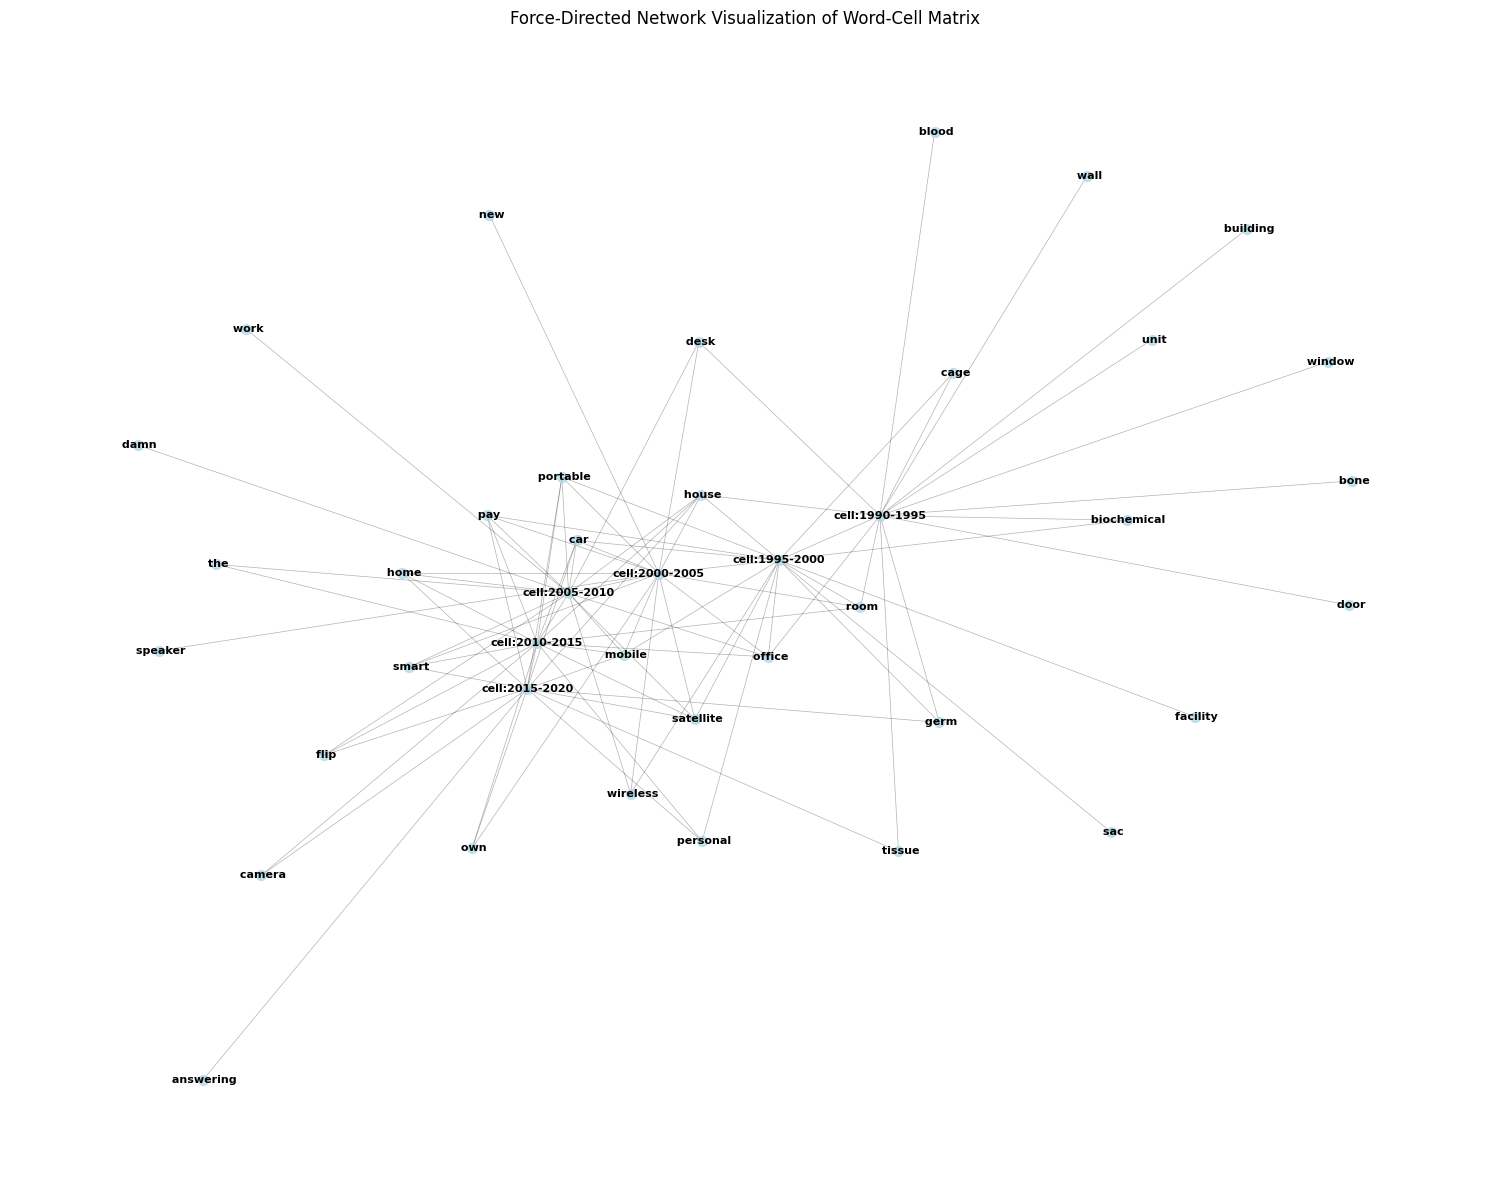

In [58]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the matrix
G = nx.Graph()

# Add nodes
for word in wordlist:
    G.add_node(word)

# Add edges based on the matrix (only add edges with significant weights)
threshold = 0.00  # Adjust this threshold as needed
for i in range(len(wordlist)):
    for j in range(i+1, len(wordlist)):
        if matrix[i, j] > threshold:
            G.add_edge(wordlist[i], wordlist[j], weight=matrix[i, j])

# Create force-directed layout
pos = nx.spring_layout(G, k=3, iterations=10000)

# Create the plot
plt.figure(figsize=(15, 12))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue', alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title('Force-Directed Network Visualization of Word-Cell Matrix')
plt.axis('off')
plt.tight_layout()
plt.show()


In [59]:
# save as ego_plotly_hover.py and run
import json
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio

# -----------------------
# 1) build a sample graph
# -----------------------

nodes = list(G.nodes())
node_index = {n: i for i, n in enumerate(nodes)}
n_nodes = len(nodes)

# adjacency list as list-of-lists indexed by node index
adj = [[] for _ in range(n_nodes)]
for u, v in G.edges():
    ui, vi = node_index[u], node_index[v]
    adj[ui].append(vi)
    adj[vi].append(ui)

# prepare edge segments grouped by which node they touch
edges_by_node = [[] for _ in range(n_nodes)]
edge_segments = []  # all edges (for base faint edges)
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_segments.append(((x0, x1, None), (y0, y1, None)))  # None creates breaks between segments
    ui, vi = node_index[u], node_index[v]
    edges_by_node[ui].append((x0, x1, y0, y1))
    edges_by_node[vi].append((x0, x1, y0, y1))

# flatten for base edge trace
edge_x = []
edge_y = []
for xs, ys in edge_segments:
    edge_x.extend(xs)
    edge_y.extend(ys)

# node coordinates
node_x = [pos[n][0] for n in nodes]
node_y = [pos[n][1] for n in nodes]
node_text = [str(n) for n in nodes]

# -----------------------
# 2) create plotly traces
# -----------------------
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1),
    hoverinfo='none',
    opacity=0.3,
    name='edges'
)

# trace that will hold highlighted edges (initially empty)
highlight_edge_trace = go.Scatter(
    x=[], y=[],
    mode='lines',
    line=dict(width=3),
    hoverinfo='none',
    opacity=0.9,
    name='highlight_edges'
)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    marker=dict(size=16, color=['#1f77b4'] * n_nodes),
    text=node_text,
    hoverinfo='text',
    name='nodes',
    customdata=list(range(n_nodes))  # handy to get index in JS
)

fig = go.Figure(data=[edge_trace, highlight_edge_trace, node_trace],
                layout=go.Layout(
                    title='Network — hover a node to highlight its ego-network',
                    showlegend=False,
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40)
                ))

# -----------------------
# 3) produce HTML and inject JS for hover behavior
# -----------------------
# Unique div id so we can target the plotly div in the JS
div_id = "ego-network-plot"

# adjacency and edges_by_node must be serializable to JS
adj_json = json.dumps(adj)
# For edges_by_node, create lists of segment coordinates as pairs to simplify JS handling
edges_by_node_js = []
for segs in edges_by_node:
    # segs is list of (x0,x1,y0,y1)
    segs_js = [[x0, x1, y0, y1] for (x0, x1, y0, y1) in segs]
    edges_by_node_js.append(segs_js)
edges_by_node_json = json.dumps(edges_by_node_js)

# Build client-side JS: attaches to plot's div, listens for plotly_hover & plotly_unhover,
# updates node colors and the highlight-edge trace.
injected_js = f"""
<script>
(function(){{
  const adj = {adj_json};
  const edges_by_node = {edges_by_node_json};
  const defaultColor = '#1f77b4';
  const highlightColor = '#d62728';
  const neighborColor = '#ff7f0e';

  const gd = document.getElementById('{div_id}');
  if(!gd) return;

  // helper to set node colors
  function colorNodes(hoverIndex) {{
    const n = adj.length;
    const colors = new Array(n).fill(defaultColor);
    if(hoverIndex !== null) {{
      colors[hoverIndex] = highlightColor;
      adj[hoverIndex].forEach(i => colors[i] = neighborColor);
    }}
    // update the node trace (trace index 2)
    Plotly.restyle(gd, {{'marker.color': [colors]}}, [2]);
  }}

  // helper to show edges connected to hoverIndex in trace index 1
  function showHighlightEdges(hoverIndex) {{
    if(hoverIndex === null) {{
      Plotly.restyle(gd, {{x:[[]], y:[[]]}}, [1]);
      return;
    }}
    const segs = edges_by_node[hoverIndex]; // [[x0,x1,y0,y1], ...]
    // Flatten into x and y arrays with None breaks
    let xs = [], ys = [];
    segs.forEach(s => {{
      xs.push(s[0]); xs.push(s[1]); xs.push(null);
      ys.push(s[2]); ys.push(s[3]); ys.push(null);
    }});
    Plotly.restyle(gd, {{x:[xs], y:[ys]}}, [1]);
  }}

  gd.on('plotly_hover', function(eventData) {{
    // eventData.points[0].pointNumber is index within the node trace if hover was on nodes.
    const pt = eventData.points && eventData.points[0];
    if(!pt) return;
    // Ensure the event is for the node trace (trace index 2)
    if(pt.fullData && pt.fullData.name === 'nodes') {{
      const idx = pt.pointIndex;
      colorNodes(idx);
      showHighlightEdges(idx);
    }}
  }});

  gd.on('plotly_unhover', function(eventData) {{
    colorNodes(null);
    showHighlightEdges(null);
  }});

  // ensure initial marker colors are set
  colorNodes(null);
}})();
</script>
"""

# get HTML string
html_str = pio.to_html(fig, full_html=True, include_plotlyjs='cdn', div_id=div_id)
# append injected JS before closing </body>
html_str = html_str.replace("</body>", injected_js + "</body>")

out_path = "ego_network_plot.html"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(html_str)

print(f"Wrote interactive ego-network HTML to: {out_path}")


Wrote interactive ego-network HTML to: ego_network_plot.html
